# Compare fits to UTUR GPS

Check UTUR timeseries for 3 models (simple linear regression, MIDAS, OSU)

Scott Henderson
1/2017

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize 
import pandas as pd

# Set enivronment variable python
import os
os.environ['UNGL_DATA'] = './'  
import gps_functions as gps


In [2]:
%matplotlib inline
#%qtconsole
plt.style.use('seaborn-white')
plt.rcParams['font.size'] = 14

In [3]:
# Update files from UNGL (http://geodesy.unr.edu/PlugNPlayPortal.php)
!wget http://geodesy.unr.edu/NGLStationPages/DataHoldings.txt
!wget http://geodesy.unr.edu/velocities/midas.IGS08.txt
!wget http://geodesy.unr.edu/NGLStationPages/steps.txt
!wget http://geodesy.unr.edu/NGLStationPages/decyr.txt
    
#!wget http://geodesy.unr.edu/gps_timeseries/tenv3/IGS08/UTUR.IGS08.tenv3 #see below

--2017-01-26 15:26:28--  http://geodesy.unr.edu/NGLStationPages/DataHoldings.txt
Resolving geodesy.unr.edu... 134.197.43.214
Connecting to geodesy.unr.edu|134.197.43.214|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1820367 (1.7M) [text/plain]
Saving to: ‘DataHoldings.txt.1’

DataHoldings.txt.1  100%[===================>]   1.74M   410KB/s    in 4.3s    

2017-01-26 15:26:35 (410 KB/s) - ‘DataHoldings.txt.1’ saved [1820367/1820367]

--2017-01-26 15:26:35--  http://geodesy.unr.edu/velocities/midas.IGS08.txt
Resolving geodesy.unr.edu... 134.197.43.214
Connecting to geodesy.unr.edu|134.197.43.214|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2676184 (2.6M) [text/plain]
Saving to: ‘midas.IGS08.txt.1’

midas.IGS08.txt.1   100%[===================>]   2.55M   412KB/s    in 6.3s    

2017-01-26 15:26:45 (412 KB/s) - ‘midas.IGS08.txt.1’ saved [2676184/2676184]

--2017-01-26 15:26:45--  http://geodesy.unr.edu/NGLStationPages/steps.txt
Resolv

In [4]:
site = 'UTUR'
dfS = gps.load_stations('DataHoldings.txt')
dfCh, dfEq = gps.load_steps(station=site) #equipment changes or earthquakes
dfM = gps.load_midas(station=site)
filename = gps.download_data(site)
df = gps.load_tenv3(filename)

UTUR already dowloaded... skipping


In [5]:
# Pisagua Earthquake (https://earthquake.usgs.gov/earthquakes/eventpage/usc000nzvd#executive)
id_eq = 'usc000nzvd'
# initialize heaviside jump
eq = pd.Timestamp('2014-04-01 23:46:47', tz='UTC')
tj = gps.decyear2date(eq.strftime('%y%b%d').upper(), True)
dfEq.query("id == @id_eq") 

,site,date,code,thresh_d,distance,mag,id
28,UTUR,2014-04-01,2,1995.262,471.823,8.2,usc000nzvd


# MIDAS automatic linear velocity 

In [6]:
print('East: {:.2f} mm/yr +/- {:.2f} mm/yr'.format(dfM.east.values[0]*1e3, dfM.err_e.values[0]*1e3))
print('North: {:.2f} mm/yr +/- {:.2f} mm/yr'.format(dfM.north.values[0]*1e3, dfM.err_n.values[0]*1e3))
print('Up: {:.2f} mm/yr +/- {:.2f} mm/yr'.format(dfM.up.values[0]*1e3, dfM.err_u.values[0]*1e3))

East: 13.48 mm/yr +/- 0.80 mm/yr
North: 14.84 mm/yr +/- 0.72 mm/yr
Up: 2.41 mm/yr +/- 1.87 mm/yr


# Simple Linear Regression


In [20]:
for comp in ['east','north','up']:
    x = df.decyear
    y = df[comp]
    z,cov = np.polyfit(x, y, 1, cov=True)
    p = np.poly1d(z)
    #print(p)
    print('{}: {:.2f} mm/yr +/- ? mm/yr'.format(comp, p[1]*1e3))
    residuals = (p(x) - y)*1e3
    rmse = np.sqrt((np.sum(residuals**2) / residuals.size))
    print('rmse = {:.2f}'.format(rmse))
    
#all at once
dfLinear = gps.fit_linear(df)

east: 10.40 mm/yr +/- ? mm/yr
rmse = 4.43
north: 17.57 mm/yr +/- ? mm/yr
rmse = 3.41
up: 4.38 mm/yr +/- ? mm/yr
rmse = 6.08
4.3732852979
10.3903448238
17.5577522535


# OSU multiparameter fit

In [8]:
# create dataframe for storing results
sites = ['UTUR']
components = ['east','north','up']
iterables = [sites, components]
index = pd.MultiIndex.from_product(iterables, names=['site','comp'])

DF = pd.DataFrame(columns=['t0','xo', 'v', 'b','tj','s1','c1','t1','s2','c2','t2','rmse'], index=index, dtype='f4')
# assign result with:
#DF.loc[('UTUR','east'),:] = popt.append(rmse)

In [9]:
# Test and plot individual station
df = gps.cull_outliers(df, cols=components) #get rid of really bogus points before fit


for comp in components:
    print('fitting {}...'.format(comp))
    # Fit OSU Model
    t0 = df.decyear[0] # intial time [yr]
    x0 = df[comp][0] # initial position [m]
    v = (df[comp][-1] - df[comp][0]) / (df.decyear[-1] - df.decyear[0])  # trend [m/yr]
    b = 0.0  # step jump offset [m]
    #tj = #see cell above above
    s1 = s2 = c1 = c2 = 0.001 # fourier coefficients [m]
    T1 = 1 # fourier period 1 [yr]
    T2 = 0.5 #fourier period 2 [yr]
    guess = [t0,x0,v,b,tj,s1,c1,s2,c2,T1,T2]

    try:
        guess = [x0,v,b,s1,c1,s2,c2]
        fit,popt,rmse = gps.invert_osu(df['decyear'], df[comp], tj, guess)
        df['fit_'+comp] = fit
        # add fixed parameters back into popt
        popt = np.insert(popt, [0,3], [t0,tj])
        popt = np.append(popt, [T1,T2])
        DF.loc[(site,comp),:] = np.append(popt,rmse)
    except Exception as e:
        print(e)
        df['fit_'+comp] = gps.osu(df.decyear.values, *guess) #plot initial guess
        pass


east: Culled 0 points
north: Culled 0 points
up: Culled 2 points
fitting east...
fitting north...
fitting up...


In [10]:
#%qtconsole
pd.set_option('precision', 4) # Limit decimal places!
DF.head()

t0      xo       v       b         tj      s1      c1  \
site comp                                                                  
UTUR east   2010.2861 -0.8367  0.0134 -0.0134  2014.2478  0.0003  0.0014   
     north  2010.2861 -0.1738  0.0158  0.0084  2014.2478 -0.0005  0.0016   
     up     2010.2861  0.0744  0.0032  0.0051  2014.2478 -0.0011 -0.0030   

                t1      s2   c2   t2    rmse  
site comp                                     
UTUR east  -0.0003  0.0002  1.0  0.5  0.0022  
     north  0.0001 -0.0006  1.0  0.5  0.0022  
     up     0.0020 -0.0003  1.0  0.5  0.0054

In [11]:
print('East: {:.2f} mm/yr +/- ? mm/yr'.format(DF.loc[('UTUR','east'),'v']*1e3))
print('North: {:.2f} mm/yr +/- ? mm/yr'.format(DF.loc[('UTUR','north'),'v']*1e3))
print('Up: {:.2f} mm/yr +/- ? mm/yr'.format(DF.loc[('UTUR','up'),'v']*1e3))

East: 13.38 mm/yr +/- ? mm/yr
North: 15.76 mm/yr +/- ? mm/yr
Up: 3.22 mm/yr +/- ? mm/yr


# Comparison Plot

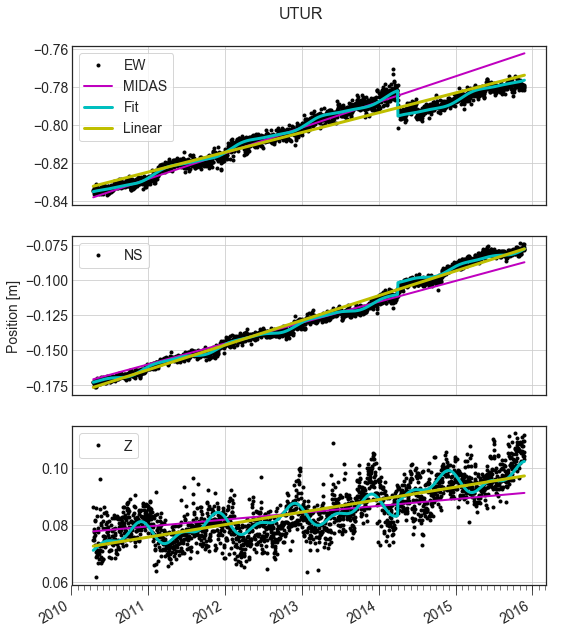

In [12]:
dfFit = df.ix[:, ['fit_up','fit_north','fit_east']]
#gps.plot_all(df, dfSteps=dfEq, dfMidas=dfM, dfFit=dfFit)
gps.plot_all(df, dfSteps=dfEq, dfMidas=dfM, dfFit=dfFit, dfExtra=dfLinear)
plt.suptitle(site, y=0.93, fontsize=16)
plt.savefig('UTUR.pdf', bbox_inches='tight')